<a href="https://colab.research.google.com/github/gatienc/multimodal_product_data_classification/blob/main/gatien_text_model_3_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*diff* : trying training on description too

In [1]:
EMBEDDING_FEATURE_SIZE=100
SEED=42
BATCH_SIZE=128

NUM_CLASSES=27




TRAIN_PERCENTAGE=0.8
VALID_PERCENTAGE=0.1


google_colab=False


# Imports

In [2]:
%pip install pandas tqdm scikit-learn imageio matplotlib wget plotly unidecode tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import copy

from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

# import for NLP
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical

import zipfile

from sklearn.metrics import f1_score
import unidecode



2024-01-30 13:19:00.876021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 13:19:00.876063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 13:19:00.877600: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 13:19:00.887806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 13:19:02.043021: W tensorflow/comp

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data loading

In [5]:
if google_colab:
# mount the drive where your dataset is availabledevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  from google.colab import drive
  drive.mount('/content/drive')
  filepath='/content/drive/MyDrive/datasets/multimodal_product_classification/' # add your own path. Where to save the dataset

  if not os.path.exists('datasets'):
    os.makedirs('datasets')
    with zipfile.ZipFile(filepath+images_name+'.zip', 'r') as zip_ref:
        zip_ref.extractall('datasets')

  datasets_path="/content/datasets/"
  save_directory="/content/drive/MyDrive/Lessons/Models/multimodal_classification/"
else:
    import wget
    if not os.path.exists('datasets'):
        os.makedirs('datasets')
        output_directory="datasets"
        csv_zip = wget.download("https://nextcloud.its-tps.fr/s/BTpB4SC93NreZxg/download/csv_data.zip",out=output_directory)
        with zipfile.ZipFile(output_directory+'/csv_data.zip', 'r') as zip_ref:
            zip_ref.extractall('datasets')
    filepath=os.getcwd()+'/datasets/'
    save_directory='../models/'
    datasets_path=filepath


# Data Preprocessing

In [6]:
# Load CSV
X_train = pd.read_csv(filepath+'X_train.csv')
y_train = pd.read_csv(filepath+'Y_train.csv')
X_train=X_train.drop(columns="Unnamed: 0")
y_train=y_train.drop(columns="Unnamed: 0")

In [7]:
# Cleaning and Preprocessing Text
CLEANR = re.compile('<.*?>') # delete html tag

def clean_html(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

def clean_text(text):
    text=clean_html(text)
    # Remove special characters and numbers
    text = unidecode.unidecode(text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

In [8]:
# Apply cleaning function to the 'designation' and "description" column
X_train['designation'] = X_train['designation'].fillna('').apply(clean_text)

get the 10 000 most used word


In [9]:
word_list = X_train['designation'].str.split()
all_words = [word for sublist in word_list for word in sublist]
# Convert the list into a pandas Series
word_series = pd.Series(all_words)

# Use value_counts() to get the counts of each unique word
word_counts = word_series.value_counts()


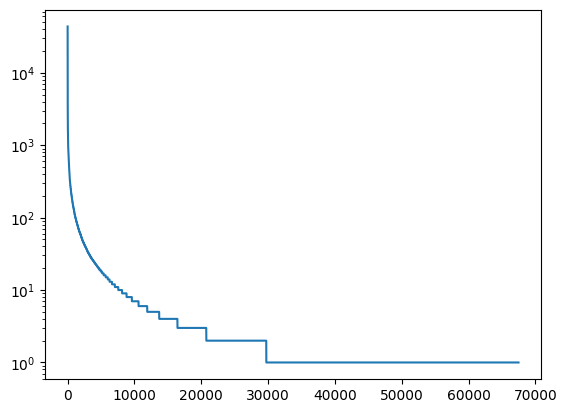

In [10]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(len(word_counts.values)),word_counts.values)
plt.yscale('log')
plt.show()

In [11]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(word_counts.index[:9999])
vocab_size = len(tokenizer.word_index) + 1

designation_sequences = tokenizer.texts_to_sequences(X_train['designation'])



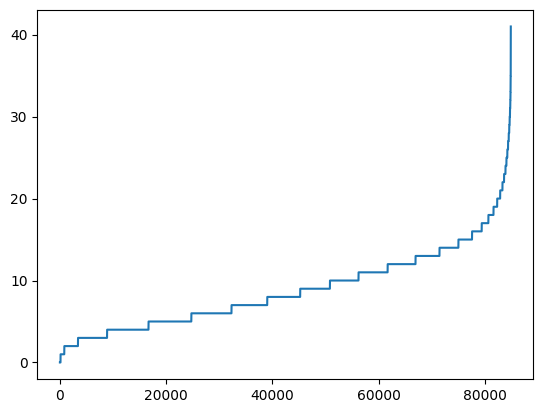

In [12]:
len_des=[len(i) for i in designation_sequences]
s_len_des=sorted(len_des)
plt.plot(s_len_des)


In [13]:
print([s_len_des[int(i* len(s_len_des))] for i in [0.9,0.95,0.99]])


[15, 17, 24]


let's pad to 20 so we get the majority of the sequences every time but not too big.

In [14]:
designation_data = pad_sequences(designation_sequences, maxlen=20)

designation_data=np.array(designation_data)
np.max(designation_data)

9999

In [15]:
# Convert labels to categorical
ohe = OneHotEncoder(sparse_output=False)
y_train_encoded = ohe.fit_transform(y_train)
np.array(y_train_encoded,dtype=float)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Dataset Creation

In [16]:
class TextDataset(Dataset):
    def __init__(self, text_input,labels):
        self.text_input = text_input
        self.labels=labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text_input = torch.tensor(self.text_input[idx]).to(device)
        label = torch.tensor(self.labels[idx], dtype=torch.float).to(device)
        return text_input, label

In [17]:
dataset=TextDataset(designation_data,y_train_encoded)

In [18]:
train_size = int(TRAIN_PERCENTAGE * len(dataset))
valid_size = int(VALID_PERCENTAGE * len(dataset))
test_size = len(dataset) - train_size - valid_size

generator = torch.Generator().manual_seed(SEED)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size],generator=generator)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)




# Model definition


In [19]:

# Define the model
class CNN_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(CNN_classifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_blocks = nn.ModuleList([
            nn.Conv2d(1, 512, (i, embedding_dim), padding=(0, 0))
            for i in range(1,7)
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * 6, embedding_dim)
        self.classif=nn.Linear(embedding_dim,num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add channel dimension for Conv2d
        conv_outputs = [nn.functional.relu(conv_block(x)).max(dim=3)[0].max(dim=2)[0] for conv_block in self.conv_blocks]# [0] to get only the values and not the indices ( in pos 1 )
        x = torch.cat(conv_outputs, dim=1)
        # Dense Layer

        # Flatten Layer
        x = x.view(x.size(0), -1)
        # Dropout Layer
        x = self.dropout(x)

        x = self.fc(x)
        x = self.classif(x)
        return x


In [20]:
# Initialize the model
num_classes = 27
model = CNN_classifier(vocab_size, EMBEDDING_FEATURE_SIZE, NUM_CLASSES)

# Convert the model to CUDA if available
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)

# Print the model summary
print(model)


CNN_classifier(
  (embedding): Embedding(10000, 100)
  (conv_blocks): ModuleList(
    (0): Conv2d(1, 512, kernel_size=(1, 100), stride=(1, 1))
    (1): Conv2d(1, 512, kernel_size=(2, 100), stride=(1, 1))
    (2): Conv2d(1, 512, kernel_size=(3, 100), stride=(1, 1))
    (3): Conv2d(1, 512, kernel_size=(4, 100), stride=(1, 1))
    (4): Conv2d(1, 512, kernel_size=(5, 100), stride=(1, 1))
    (5): Conv2d(1, 512, kernel_size=(6, 100), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (classif): Linear(in_features=100, out_features=27, bias=True)
)


In [22]:
def train_model(model,train_dataloader,val_loader,num_epochs=10):  # Train the model
  val_f1=0
  max_val_f1=0
  val_losses=[]
  train_losses=[]
  val_loss=0
  train_loss=0

  for epoch in tqdm(range(num_epochs)):
      model.train()
      val_loss=0
      train_loss=0
      last_until_better=0
      for inputs, labels in tqdm(train_dataloader,desc=f"Epoch {epoch + 1}/{num_epochs}, Validation F1 Score: {val_f1:.4f}"):
          optimizer.zero_grad()
          outputs = model(inputs)
          outputs=outputs.squeeze(0)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          with torch.no_grad():
            train_loss+=loss
      exp_lr_scheduler.step()


      model.eval()
      with torch.no_grad():
          val_preds = []
          val_labels = []
          for val_inputs, val_labels_batch in val_loader:
              val_outputs = model(val_inputs)
              loss = criterion(val_outputs, val_labels_batch)
              val_loss+=loss
              val_preds.append(val_outputs.cpu())
              val_labels.append(val_labels_batch.cpu())

      val_preds = torch.cat(val_preds, dim=0)
      val_labels = torch.cat(val_labels, dim=0)


      plot_loss(val_losses,train_losses)#plot the loss at each epoch


      val_f1 = f1_score(torch.argmax(val_labels,dim=1), torch.argmax(val_preds, dim=1), average='macro')
      if val_f1>max_val_f1:
        last_until_better=0
        max_val_f1=val_f1
        torch.save(model.state_dict(), save_directory + 'Text_model_val_f1_{:.3f}_epoch{}.ckpt'.format(val_f1,epoch))
        best_model_wts = copy.deepcopy(model.state_dict())
      else:
        last_until_better+=1
      if last_until_better>3:
        break


  model.load_state_dict(best_model_wts)
  return(model,max_val_f1)


In [25]:
import plotly.graph_objects as go

fig = go.FigureWidget()

# Add traces
fig.add_scatter(x=[], y=[], mode='lines', name='Training Loss')
fig.add_scatter(x=[], y=[], mode='lines', name='Validation Loss')

# Set titles and labels
fig.layout.title="Training and Validation Loss"
# , xaxis_title="Epochs", yaxis_title="Loss")


fig

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Training Loss',
              'type': 'scatter',
              'uid': '418f10ce-5471-43c9-a7e3-6e24650d84f7',
              'x': [],
              'y': []},
             {'mode': 'lines',
              'name': 'Validation Loss',
              'type': 'scatter',
              'uid': '5cc2a04a-488f-4acb-a2c8-216387c384da',
              'x': [],
              'y': []}],
    'layout': {'template': '...', 'title': {'text': 'Training and Validation Loss'}}
})

In [26]:
def plot_loss(train_losses,val_losses):
   # Update data
   print("updating graph")
   with fig.batch_update():
    epoch_range=list(range(len(val_losses)))
    fig.data[0].x = epoch_range
    fig.data[0].y = train_losses
    fig.data[1].x = epoch_range
    fig.data[1].y = val_losses



In [27]:
model,max_val_f1=train_model(model,train_dataloader,valid_dataloader,num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Validation F1 Score: 0.0000:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 2/20, Validation F1 Score: 0.7609:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 3/20, Validation F1 Score: 0.7664:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 4/20, Validation F1 Score: 0.7659:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 5/20, Validation F1 Score: 0.7724:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 6/20, Validation F1 Score: 0.7718:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 7/20, Validation F1 Score: 0.7720:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 8/20, Validation F1 Score: 0.7724:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 9/20, Validation F1 Score: 0.7716:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 10/20, Validation F1 Score: 0.7741:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 11/20, Validation F1 Score: 0.7751:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 12/20, Validation F1 Score: 0.7727:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 13/20, Validation F1 Score: 0.7738:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 14/20, Validation F1 Score: 0.7738:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 15/20, Validation F1 Score: 0.7744:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 16/20, Validation F1 Score: 0.7755:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 17/20, Validation F1 Score: 0.7753:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 18/20, Validation F1 Score: 0.7746:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 19/20, Validation F1 Score: 0.7750:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


Epoch 20/20, Validation F1 Score: 0.7747:   0%|          | 0/531 [00:00<?, ?it/s]

updating graph


In [52]:
@torch.no_grad 
def test_model(model,test_dataloader):  # Train the model
    val_f1=0
    model.eval()
    val_preds = []
    val_labels = []
    for val_inputs, val_labels_batch in tqdm(test_dataloader):
        val_outputs = model(val_inputs)
        val_preds.extend(torch.argmax(val_outputs,dim=1).cpu().numpy())
        val_labels.extend(torch.argmax(val_labels_batch,dim=1).cpu().numpy())

    return(np.array(val_preds),np.array(val_labels))


In [53]:
val_preds,val_labels=test_model(model,test_dataloader)

  0%|          | 0/67 [00:00<?, ?it/s]

In [54]:
val_preds

array([19, 23, 16, ...,  0,  5, 21])

In [55]:
val_labels

array([19,  5, 16, ...,  0,  5, 21])

In [56]:
sum(val_preds==val_labels)/len(val_preds)

0.7950076533615918

# Test part

In [57]:
X_test = pd.read_csv(filepath+'X_test.csv')
X_test=X_test.drop(columns="Unnamed: 0")
X_test['designation'] = X_test['designation'].fillna('').apply(clean_text)
sequences = tokenizer.texts_to_sequences(X_test['designation'])

# Padding to max length of text
data = pad_sequences(sequences, maxlen=34)


In [58]:
print(data)

[[   0    0    0 ... 1678   47 5857]
 [   0    0    0 ...   46   29 1049]
 [   0    0    0 ...  181 3704 5318]
 ...
 [   0    0    0 ... 1433   75   12]
 [   0    0    0 ... 1795 3115 2385]
 [   0    0    0 ...    7    4   63]]


In [59]:
model.to(device)
model.eval()

CNN_classifier(
  (embedding): Embedding(10000, 100)
  (conv_blocks): ModuleList(
    (0): Conv2d(1, 512, kernel_size=(1, 100), stride=(1, 1))
    (1): Conv2d(1, 512, kernel_size=(2, 100), stride=(1, 1))
    (2): Conv2d(1, 512, kernel_size=(3, 100), stride=(1, 1))
    (3): Conv2d(1, 512, kernel_size=(4, 100), stride=(1, 1))
    (4): Conv2d(1, 512, kernel_size=(5, 100), stride=(1, 1))
    (5): Conv2d(1, 512, kernel_size=(6, 100), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (classif): Linear(in_features=100, out_features=27, bias=True)
)

In [74]:
val_preds = []
with torch.no_grad():
  for input in tqdm(data):
      input=torch.from_numpy(input)
      input=input.to(device)
      input=input.unsqueeze(0)
      val_outputs = model(input)[0]
      val_outputs=val_outputs.detach().cpu().numpy()
      val_preds.append(val_outputs)

  0%|          | 0/13812 [00:00<?, ?it/s]

In [75]:
val_preds2=np.argmax(val_preds,axis=1)
val_preds3=[]
for val in val_preds2:
    zero=np.zeros((27))
    zero[val-1]=1
    val_preds3.append(zero)
val_preds3

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0.

In [76]:
val_preds=ohe.inverse_transform(val_preds)

In [77]:
df_preds=pd.DataFrame(val_preds,columns='prdtypecode')
df_preds=df_preds.set_index(df_preds.index+84916)

In [78]:
df_preds

,0
84916,2403
84917,1160
84918,2583
84919,2583
84920,2522
...,...
98723,1280
98724,2403
98725,2583
98726,2582


In [79]:
df_preds.to_csv("eval_text_designation.csv")